In [3]:
from glob import glob
import pandas as pd

In [29]:
# Opción que deshabilita el limite de columnas y filas mostradas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

---
## Carga de data Yelp

In [4]:
# Path de los archivos no-procesados (formato parquet)
path_data = '../data/raw'

### `y-business.parquet`

In [5]:
df_business = pd.read_parquet(f'{path_data}/y-business.parquet')

### `y-checkin.parquet`

In [32]:
df_checkin = pd.read_parquet(f'{path_data}/y-checkin.parquet')

### `y-tip.parquet`

In [33]:
df_tip = pd.read_parquet(f'{path_data}/y-tip.parquet')

### `y-review.parquet`

In [34]:
# Crear lista de archivos en /data/raw/y-review/
review_parquets = glob(f'{path_data}/y-review/*')
review_parquets

['../data/raw/y-review/y-review_03.parquet',
 '../data/raw/y-review/y-review_02.parquet',
 '../data/raw/y-review/y-review_01.parquet']

In [35]:
# Crear dataframe donde se unen los datos extraidos de parquet
df_review = pd.DataFrame()
# Iterar por cada parquet dentro de /data/raw/y-review/
for p in review_parquets:
    # Leer parquet
    df = pd.read_parquet(p)
    # Unir a df_review
    df_review = pd.concat([df_review, df], ignore_index=True)

### `y-user.parquet`

In [6]:
# Crear lista de archivos en /data/raw/y-user/
user_parquets = glob(f'{path_data}/y-user/*')
user_parquets

['../data/raw/y-user/y-user_04.parquet',
 '../data/raw/y-user/y-user_02.parquet',
 '../data/raw/y-user/y-user_03.parquet',
 '../data/raw/y-user/y-user_01.parquet']

In [7]:
# Crear dataframe donde se unen los datos extraidos de parquet
df_user = pd.DataFrame()
# Iterar por cada parquet dentro de /data/raw/y-user/
for p in user_parquets:
    # Leer parquet
    df = pd.read_parquet(p)
    # Unir a df_user
    df_user = pd.concat([df_user, df], ignore_index=True)

---
## Análisis Exploratorio

In [38]:
# Revisar el dataset e imprimir las primeras filas
print(df_business.info())
df_business.head()

<class 'pandas.core.frame.DataFrame'>
Index: 150351 entries, 0 to 1543
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150351 non-null  object 
 1   name          150351 non-null  object 
 2   address       150351 non-null  object 
 3   city          150351 non-null  object 
 4   state         150348 non-null  object 
 5   postal_code   150351 non-null  object 
 6   latitude      150351 non-null  float64
 7   longitude     150351 non-null  float64
 8   stars         150351 non-null  float64
 9   review_count  150351 non-null  int64  
 10  is_open       150351 non-null  int64  
 11  attributes    136607 non-null  object 
 12  categories    150248 non-null  object 
 13  hours         127128 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 17.2+ MB
None


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,None,93101,34.426679,-119.711197,5.0,7,0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,None,63123,38.551126,-90.335695,3.0,15,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Shipping Centers, Local Services, Notaries, Ma...","{'Friday': '8:0-18:30', 'Monday': '0:0-0:0', '..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,None,85711,32.223236,-110.880452,3.5,22,0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Department Stores, Shopping, Fashion, Home & G...","{'Friday': '8:0-23:0', 'Monday': '8:0-22:0', '..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Friday': '7:0-21:0', 'Monday': '7:0-20:0', '..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Brewpubs, Breweries, Food","{'Friday': '12:0-22:0', 'Monday': None, 'Satur..."


In [39]:
# Completar los nulos con espacio para poder filtrar por categoría
df_business['categories'] = df_business['categories'].fillna('')

In [40]:
# Dejar en el dataset solo la categoría 'Restaurants'
filtro_categoria = 'Restaurants'
df_business = df_business[df_business['categories'].str.contains(filtro_categoria, case=False)]
df_business.shape

(52268, 14)

In [41]:
# Filtramos los datos a la región elegida
estados_filtro = ["DE", "NJ", "PA"]
df_business = df_business[df_business['state'].isin(estados_filtro)]
df_business.shape

(15414, 14)

In [42]:
# Revisar los datos nuevamente
df_business.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15414 entries, 22 to 150340
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   15414 non-null  object 
 1   name          15414 non-null  object 
 2   address       15414 non-null  object 
 3   city          15414 non-null  object 
 4   state         15414 non-null  object 
 5   postal_code   15414 non-null  object 
 6   latitude      15414 non-null  float64
 7   longitude     15414 non-null  float64
 8   stars         15414 non-null  float64
 9   review_count  15414 non-null  int64  
 10  is_open       15414 non-null  int64  
 11  attributes    15239 non-null  object 
 12  categories    15414 non-null  object 
 13  hours         13215 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 1.8+ MB


Solo tenemos algunos nulos en "attributes" y "hours", que por el momento no se van a rellenar, hasta decidir si estas columnas serán utilizadas para los análisis.

In [43]:
# Revisar las columnas numéricas
df_business.describe()

,latitude,longitude,stars,review_count,is_open
count,15414.000000,15414.000000,15414.000000,15414.000000,15414.000000
mean,36.996730,-87.809662,3.508726,89.138575,0.661931
std,6.001368,13.757462,0.832169,197.681018,0.473068
min,27.674685,-120.000083,1.000000,5.000000,0.000000
25%,32.219742,-90.225726,3.000000,13.000000,0.000000
50%,39.474340,-86.044822,3.500000,33.000000,1.000000
75%,39.956275,-75.335114,4.000000,89.000000,1.000000
max,53.679197,-74.684399,5.000000,6093.000000,1.000000


No se observan valores erróneos, como latitud y longitud con signo invertido, o calificaciones fuera del intérvalo 1 a 5.

Por el momento se va a mantener como está, hasta decidir si alguna de las "keys" puede ser de utilidad para algún análisis, y en ese caso se prodecerá a desanidar los datos.

In [44]:
# Revisar nombres de columnas
df_business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

#### Las siguientes columnas serán eliminadas:

addres: Se cuenta con los datos de latitud y longitud  
is_open: Se entiende que se refiere al momento de la extracción de los datos. Se cuenta con los horarios de apertura y cierre


In [45]:
# Eliminar las columnas antes mencionadas
df_business.drop("address", axis=1, inplace=True)
df_business.drop("is_open", axis=1, inplace=True)

In [46]:
df_business.to_parquet(f'{path_data}/etl-business.parquet')

#### SE VA A EXTRAER A UN NUEVO ARCHIVO EL CONTENIDO DE LA COLUMNA "attributes", y se va a eliminar la misma del dataset de "business"

In [47]:
# Abrir el archivo guardado en una sesión anterior
df_business = pd.read_parquet(f'{path_data}/etl-business.parquet')

In [48]:
# Crear un dataframe nuevo para los atributos
df_attributes = df_business[["business_id", "attributes"]]

In [49]:
# Reiniciar elíndice
df_attributes.reset_index(drop=True, inplace=True)


In [50]:
type(df_attributes["attributes"][0])

dict

In [51]:
# Buscar la primera fila que tenga atributos y extraer el diccionario para usar las llaves en la creación de las columnas del dataframe
contador = 0
total = df_attributes.shape[0]
while contador < total:
    if type(df_attributes["attributes"][contador]) != dict:
        pass
    else:
        diccionario = df_attributes["attributes"][contador]
        break

    contador +=1

In [52]:
diccionario.keys()

dict_keys(['AcceptsInsurance', 'AgesAllowed', 'Alcohol', 'Ambience', 'BYOB', 'BYOBCorkage', 'BestNights', 'BikeParking', 'BusinessAcceptsBitcoin', 'BusinessAcceptsCreditCards', 'BusinessParking', 'ByAppointmentOnly', 'Caters', 'CoatCheck', 'Corkage', 'DietaryRestrictions', 'DogsAllowed', 'DriveThru', 'GoodForDancing', 'GoodForKids', 'GoodForMeal', 'HairSpecializesIn', 'HappyHour', 'HasTV', 'Music', 'NoiseLevel', 'Open24Hours', 'OutdoorSeating', 'RestaurantsAttire', 'RestaurantsCounterService', 'RestaurantsDelivery', 'RestaurantsGoodForGroups', 'RestaurantsPriceRange2', 'RestaurantsReservations', 'RestaurantsTableService', 'RestaurantsTakeOut', 'Smoking', 'WheelchairAccessible', 'WiFi'])

In [53]:
for key in diccionario.keys():
    df_attributes[key] = "None"

/tmp/ipykernel_114772/1579500107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_attributes[key] = "None"
/tmp/ipykernel_114772/1579500107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_attributes[key] = "None"
/tmp/ipykernel_114772/1579500107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [54]:

contador = 0
total = df_attributes.shape[0]
while contador < total:
    if type(df_attributes["attributes"][contador]) != dict:
        pass
    else:
        dicc = df_attributes["attributes"][contador]
        for key in dicc.keys():
            df_attributes[key][contador] = dicc[key][0]

    contador +=1

TypeError: 'NoneType' object is not subscriptable

In [ ]:
#df_business.to_parquet(f'{path_data}/etl-business.parquet')

-------------------

In [ ]:
# Revisar el dataset
print(df_checkin.info())
df_checkin.head()

#### En principio no vamos a realizar análisis que incluyan la fecha y hora de ingreso de los usuarios al local. Este dataset no se va a utilizar, por lo que no se va a desanidar la columna de registros (date), ni se va a realizar ningún otro proceso sobre el mismo. Se observa de todos modos que el dataset no contiene valores nulos.

-------------------

In [ ]:
# Revisar el dataset
print(df_tip.info())
df_tip.head()


In [ ]:
df_tip.describe()

Los datos no contienen nulos y están en el formato correcto.

In [ ]:
# Sacar los id de los locales elegidos en el dataset de Business
locales_elegidos = df_business["business_id"]

In [ ]:
# Filtrar los tips
df_tip = df_tip[df_tip["business_id"].isin(locales_elegidos)]
df_tip.shape


In [ ]:
df_tip.to_parquet(f'{path_data}/etl-tip.parquet')

In [ ]:
df_user.info()

## EDA 2

In [56]:
print('las columnas de business son:', df_business.columns)
print('las columnas de checkin son:', df_checkin.columns)
print('las columnas de tip son:', df_tip.columns)
print('las columnas de user son:', df_user.columns)

las columnas de business son: Index(['business_id', 'name', 'city', 'state', 'postal_code', 'latitude',
       'longitude', 'stars', 'review_count', 'attributes', 'categories',
       'hours'],
      dtype='object')
las columnas de checkin son: Index(['business_id', 'date'], dtype='object')
las columnas de tip son: Index(['user_id', 'business_id', 'text', 'date', 'compliment_count'], dtype='object')
las columnas de user son: Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')


In [57]:
df_review_filtrado = pd.read_parquet(r'/home/henry/PF/Henry_PF/data/raw/y-review_filtrado.parquet')

In [58]:
print('las columnas de review_filtrado son:', df_review_filtrado.columns)

las columnas de review_filtrado son: Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'state'],
      dtype='object')


corroboramos la información de la columna state en las reviews de yelp:

In [59]:
df_review_filtrado['state'].value_counts()

state
PA    1578421
NJ     408549
DE     110842
Name: count, dtype: int64

Se desea analizar la puntuación en estrellas por estado: 

In [90]:
import matplotlib.pyplot as plt


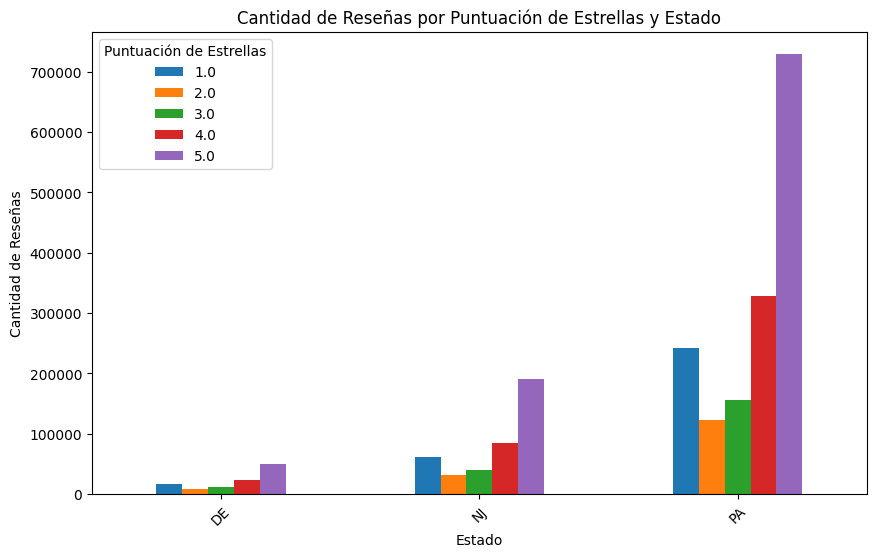

In [61]:
# Agrupar por estado y puntuación de estrellas, y contar el número de reseñas
reseñas_por_estado = df_review_filtrado.groupby(['state', 'stars']).size().unstack(fill_value=0)

# Crear un gráfico de barras para visualizar las reseñas por estado y puntuación de estrellas
reseñas_por_estado.plot(kind='bar', figsize=(10, 6))
plt.title('Cantidad de Reseñas por Puntuación de Estrellas y Estado')
plt.xlabel('Estado')
plt.ylabel('Cantidad de Reseñas')
plt.xticks(rotation=45)
plt.legend(title='Puntuación de Estrellas')
plt.show()


Filtramos los restaurants de la cadena Darden en el DataFrame de business:

In [62]:
# Nombres específicos a buscar
nombres_especificos = [
    'olive garden', 'longhorn steakhouse', 'yard house', 
    "ruth's chris steak house", "cheddar's scratch kitchen", 
    'the capital grille', 'seasons 52', "eddiev's", 
    'bahama breeze'
]

# Convertir los nombres a minúsculas para hacer la búsqueda insensible a mayúsculas y minúsculas
nombres_especificos = [nombre.lower() for nombre in nombres_especificos]

# Filtrar el DataFrame por los nombres específicos
df_filtrado_nombres = df_business[df_business['name'].str.lower().str.contains('|'.join(nombres_especificos), case=False)]

df_filtrado_nombres.head(2)

,business_id,name,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,hours
6494,DszOO6k_s2wuGhTw2AsUdA,Olive Garden Italian Restaurant,Fairview Heights,NJ,62208,38.601598,-89.987977,3.0,97,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Salad, Restaurants, Nightlife, Bars, Wine Bars...","{'Friday': '11:0-23:0', 'Monday': '0:0-0:0', '..."
10990,kHuIRfZq3aadONNFO0vEnQ,Cheddar's Scratch Kitchen,Mt Juliet,PA,37122,36.174322,-86.513826,3.0,155,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Comfort Food, Restaurants, Southern, American ...","{'Friday': '11:0-23:0', 'Monday': '0:0-0:0', '..."


In [63]:
# Contar la cantidad de negocios para cada nombre específico
conteo_por_nombre = df_filtrado_nombres['name'].value_counts()

# Mostrar los resultados
print(conteo_por_nombre)



name
Olive Garden Italian Restaurant    11
LongHorn Steakhouse                 9
Ruth's Chris Steak House            5
Cheddar's Scratch Kitchen           3
Bahama Breeze                       2
Seasons 52                          2
Yard House                          1
Name: count, dtype: int64


In [64]:
# Convertir los nombres a minúsculas para hacer la búsqueda insensible a mayúsculas y minúsculas
nombres_especificos = [nombre.lower() for nombre in nombres_especificos]

# Filtrar el DataFrame por los nombres específicos
df_filtrado_nombres = df_business[df_business['name'].str.lower().isin(nombres_especificos)]

# Agrupar por nombre, asumiendo que cada nombre tiene asociadas las mismas categorías
categorias_por_nombre = df_filtrado_nombres.groupby('name')['categories'].unique().reset_index()

# Mostrar los resultados de manera más legible
categorias_por_nombre


,name,categories
0,Bahama Breeze,"[Nightlife, Bars, Seafood, Latin American, Lao..."
1,Cheddar's Scratch Kitchen,"[Comfort Food, Restaurants, Southern, American..."
2,LongHorn Steakhouse,"[Restaurants, Barbeque, Steakhouses, American ..."
3,Ruth's Chris Steak House,"[Steakhouses, Restaurants, Event Planning & Se..."
4,Seasons 52,"[American (Traditional), Gluten-Free, Steakhou..."
5,Yard House,"[American (New), Vegetarian, Nightlife, Bars, ..."


# Usuarios

In [8]:
df_user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,R2_X4JUcWU23pqPHUsy-Og,Ella,1,2013-09-24 13:09:03,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
1,tkRvU4QtOLsZpcEMaq2yUg,Cassie,2,2017-05-12 17:59:06,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
2,vAjua3ix-mjnKbtCMeXFww,John,9,2019-08-31 23:57:57,5,0,2,,None,0,...,0,0,0,0,0,0,0,0,0,0
3,qoYIkDkDJM1a_lIdW_Kc_g,Jack,1,2013-06-25 03:45:36,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
4,NzcdNm3xRR_6lG1TGTKw4Q,Megan,7,2021-08-26 18:01:09,1,1,0,,None,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2105597 entries, 0 to 2105596
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             string 
 1   name                string 
 2   review_count        int64  
 3   yelping_since       string 
 4   useful              int64  
 5   funny               int64  
 6   cool                int64  
 7   elite               string 
 8   friends             string 
 9   fans                int64  
 10  average_stars       float64
 11  compliment_hot      int64  
 12  compliment_more     int64  
 13  compliment_profile  int64  
 14  compliment_cute     int64  
 15  compliment_list     int64  
 16  compliment_note     int64  
 17  compliment_plain    int64  
 18  compliment_cool     int64  
 19  compliment_funny    int64  
 20  compliment_writer   int64  
 21  compliment_photos   int64  
dtypes: float64(1), int64(16), string(5)
memory usage: 353.4 MB


En primer lugar se descartan las columnas de cumplidos hacia los usuarios

In [9]:
df_user_filtrado = df_user[['user_id','name', 'review_count', 'yelping_since',
       'useful', 'funny', 'cool', 'elite', 'friends', 'fans', 'average_stars']]

Se determinara si se tiene pasajeros sospechosos que con una cantidad apreciable de reseñas siempre puntuen con 5 o 1 estrella, que solo hayan hecho una reseña o que presenten nombres extraños. 

In [10]:
#Condiciones de usuarios sospechosos
mask_1 = (df_user_filtrado.average_stars == 5) & (df_user_filtrado.review_count > 4)
mask_2 = (df_user_filtrado.average_stars == 1) & (df_user_filtrado.review_count > 4) # Estas dos primeras condiciones son para evitar reseñas fuertemente sesgadas positiva o negativamente
mask_3 = (df_user_filtrado.review_count == 1) #No se tomaran en cuenta usuarios que hayan escrito una unica reseña
mask_4 = (df_user_filtrado.name.str.len() <= 2) | df_user_filtrado.name.str.contains('\.')#Esto es para filtrar nombres extraños como los que presentan 1 o 2 letras o los que contienen puntos

#Se define un nuevo df sin los usuarios sospechosos
df_user_filtrado = df_user_filtrado[~(mask_1) & ~(mask_2) & ~(mask_3) & ~(mask_4)]


In [13]:
print("Cantidad de usuarios luego de filtrar:", len(df_user_filtrado))
print("Cantidad de usuarios totales:", len(df_user))

Cantidad de usuarios luego de filtrar: 1620338
Cantidad de usuarios totales: 2105597


A continuacion se  analizan las reviews de los usuario considerados como elite en algun año.

In [37]:
df_user_elite = df_user_filtrado[(df_user_filtrado.elite.notna()) & (df_user_filtrado.elite != "" )]
print("Cantidad de usuarios elite:", len(df_user_elite))

Cantidad de usuarios elite: 114997


In [87]:
df_user_filtrado[["review_count","average_stars"]].describe()


,review_count,average_stars
count,1.620338e+06,1.620338e+06
mean,3.482738e+01,3.712126e+00
std,1.159903e+02,9.289443e-01
min,0.000000e+00,1.000000e+00
25%,3.000000e+00,3.200000e+00
50%,9.000000e+00,3.850000e+00
75%,2.500000e+01,4.380000e+00
max,1.747300e+04,5.000000e+00


In [88]:
df_user_elite[["review_count","average_stars"]].describe()

,review_count,average_stars
count,114997.000000,114997.000000
mean,252.491578,3.949815
std,343.087628,0.353358
min,2.000000,2.310000
25%,89.000000,3.710000
50%,155.000000,3.950000
75%,290.000000,4.190000
max,17473.000000,4.990000


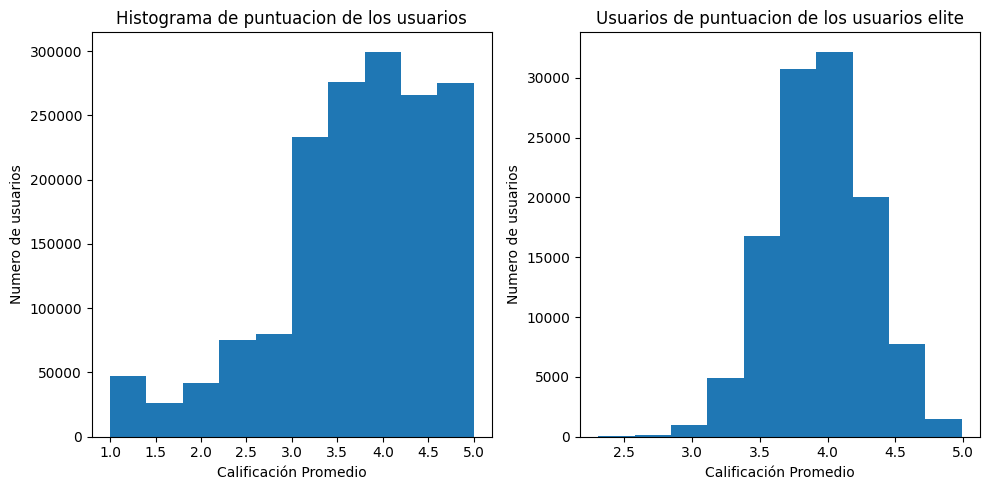

In [78]:
# Crear subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))


ax1.hist(df_user_filtrado.average_stars)
ax1.set_title('Histograma de puntuacion de los usuarios')
ax1.set_xlabel('Calificación Promedio')
ax1.set_ylabel('Numero de usuarios')


ax2.hist(df_user_elite.average_stars)
ax2.set_title('Usuarios de puntuacion de los usuarios elite')
ax2.set_xlabel('Calificación Promedio')
ax2.set_ylabel('Numero de usuarios')

# Ajustar diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Ambas distribuciones se encuentran sesgadas a la izquierda, sin embargo la del promedio de las puntuaciones de los usuarios elite se asemeja mucho mas a una distribucion normal. 

In [61]:
def contar_amigos(friends):
    if friends == "None":
        return 0
    else:
        return len(friends.split(','))

df_user_elite['num_friends'] = df_user_elite['friends'].apply(contar_amigos)
df_user_filtrado['num_friends'] = df_user_filtrado['friends'].apply(contar_amigos)

/tmp/ipykernel_120049/3531567544.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_elite['num_friends'] = df_user_elite['friends'].apply(contar_amigos)


Tambien es importante destacar que estos usuarios son mas influyentes, ya que presentan una mayor cantidad de fans y amigos. 

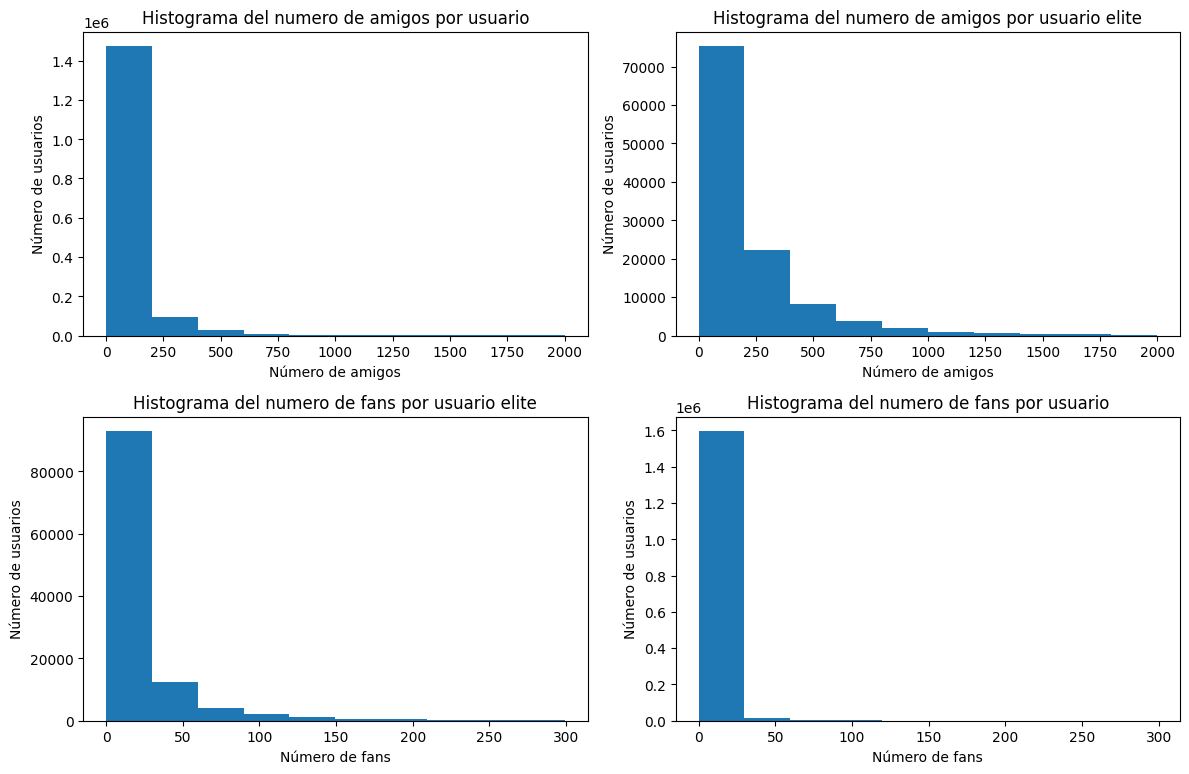

In [76]:
# Crear una figura y ejes para los subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Graficar el primer histograma en el primer subgráfico
axs[0, 0].hist(df_user_filtrado[df_user_filtrado.num_friends < 2000].num_friends)
axs[0, 0].set_title('Histograma del numero de amigos por usuario')
axs[0, 0].set_xlabel('Número de amigos')
axs[0, 0].set_ylabel('Número de usuarios')

# Graficar el segundo histograma en el segundo subgráfico
axs[0, 1].hist(df_user_elite[df_user_elite.num_friends < 2000].num_friends)
axs[0, 1].set_title('Histograma del numero de amigos por usuario elite')
axs[0, 1].set_xlabel('Número de amigos')
axs[0, 1].set_ylabel('Número de usuarios')

# Graficar el tercer histograma en el tercer subgráfico
axs[1, 0].hist(df_user_elite[df_user_elite.fans < 300].fans)
axs[1, 0].set_title('Histograma del numero de fans por usuario elite')
axs[1, 0].set_xlabel('Número de fans')
axs[1, 0].set_ylabel('Número de usuarios')

# Graficar el cuarto histograma en el cuarto subgráfico
axs[1, 1].hist(df_user_filtrado[df_user_filtrado.fans < 300].fans)
axs[1, 1].set_title('Histograma del numero de fans por usuario')
axs[1, 1].set_xlabel('Número de fans')
axs[1, 1].set_ylabel('Número de usuarios')

# Ajustar espaciado entre subgráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

---

## Mapa

In [6]:
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [7]:
df_business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [33]:
def crear_plot_mapa(df: pd.DataFrame) -> plt.Figure:
    """Devuelve una grafica tipo plt.Figure, con un Shapefile que
    presenta el territorio de USA, y el dataframe de entrada con
    columnas de coordinadas ('longitude', 'latitude').
    """
    # Descartar los nulos
    df = df.dropna(axis=0, subset=['longitude', 'latitude'])

    # Crear un GeoDataFrame con la data de coordinadas
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = GeoDataFrame(df, geometry=geometry)

    # Cargar archivo shapefile
    mapa = gpd.read_file('../assets/map_state_5m.shp')

    # Calculamos los limites del mapa
    minx, miny, maxx, maxy = gdf.total_bounds

    # Creamos los plots del mapa
    plt.figure()  # limpiar memory de plotly
    fig, ax = plt.subplots(figsize=(12, 10))
    mapa.plot(ax=ax, color='white', edgecolor='black')
    gdf.plot(ax=ax, marker='o', color='red', markersize=.001)

    # Calculamos el margen del grafico
    margin_ratio = 0.2
    marginx = (maxx - minx) * margin_ratio
    marginy = (maxy - miny) * margin_ratio
    # Aplicamos los margenes en relacion a los plots en los extremos
    ax.set_xlim(minx - marginx, maxx + marginx)
    ax.set_ylim(miny - marginy, maxy + marginy)

    return plt

<Figure size 640x480 with 0 Axes>

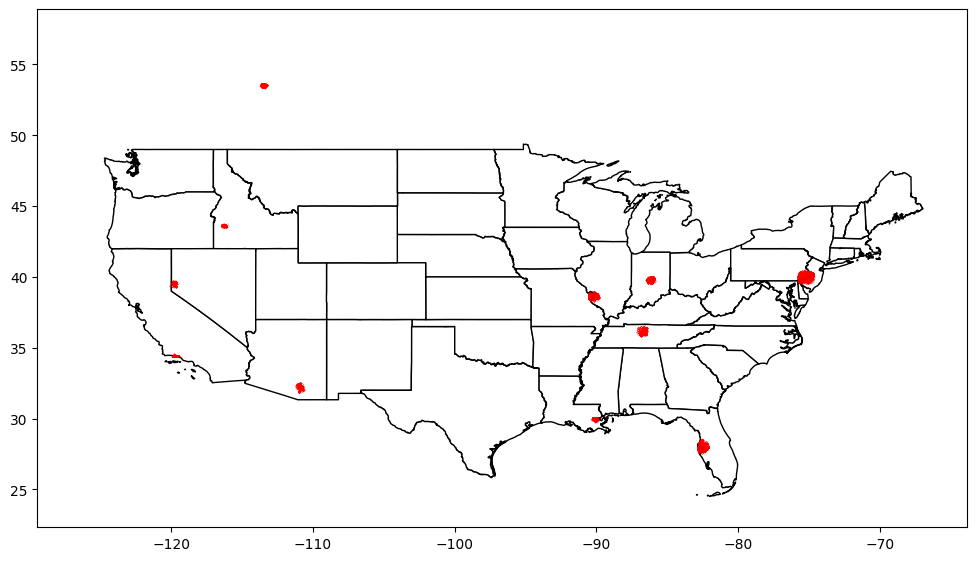

In [34]:
mapa_business = crear_plot_mapa(df_business)
mapa_business.show()

### Mapa: area metro Philadelphia (PA, NJ, DE)

In [ ]:
# Filtrar area geografica de interes
estados = ['PA', 'NJ', 'DE']

df_estados = df_business[df_business['state'].isin(estados)]
df_estados['state'].value_counts()

state
PA    34040
NJ     8537
DE     2265
Name: count, dtype: int64

In [ ]:
df_estados.shape  # expected value: (44842, 14)

(44842, 14)

In [ ]:
"""     !!  No devuelve output esperado (mapa no se filtra)


df = df_estados

# Descartar nulos
#df = df_estados.dropna(axis=0, subset=['longitude', 'latitude'])

# Crear un GeoDataFrame con la data de coordinadas

geo = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geo)

# Cargar archivo shapefile
mapa = gpd.read_file('../assets/states_500k.shp')

# Calculamos los limites del mapa
minx, miny, maxx, maxy = gdf.total_bounds

# Creamos los plots del mapa

plt.figure()  # clean up

fig, ax = plt.subplots(figsize=(12, 9))
mapa.plot(ax=ax, color='white', edgecolor='black')

gdf = gdf[gdf.is_valid | gdf.buffer(0).is_valid]  # clean up

gdf.plot(ax=ax, marker='o', color='red', markersize=.0001)

# Calculamos el margen del grafico
margin_ratio = 0.2
marginx = (maxx - minx) * margin_ratio
marginy = (maxy - miny) * margin_ratio
# Aplicamos los margenes en relacion a los plots en los extremos
ax.set_xlim(minx - marginx, maxx + marginx)
ax.set_ylim(miny - marginy, maxy + marginy)

plt.show()"""